In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import json
from typing import Dict, List, Tuple
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch  
from scipy.ndimage import gaussian_filter1d

plt.style.use('default')
plt.rcParams.update({
    'figure.figsize': [8.0, 6.0],
    'figure.dpi': 300,
    'font.size': 10,
    'svg.fonttype': 'none',
    'figure.titlesize': 9,
    'axes.titlesize': 9,
    'axes.labelsize': 8,
    'ytick.labelsize': 7,
    'xtick.labelsize': 7,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white'
})

In [2]:
 # Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Setup paths
scratch_dir = os.getenv("SCRATCH_DIR")

In [3]:
# %%
# Base directory for analysis outputs
OUTPUT_DIR = Path(scratch_dir) / "output_RR"
SAVE_DIR = Path(OUTPUT_DIR) / "00_final_figures"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Groups and their data paths
GROUPS = ['affair', 'paranoia', 'combined']

# Colors for plotting
COLORS = {
    'affair': '#E1BE6A',      # Yellow/colorblind friendly
    'affair_light': '#F2CB69', # Light yellow/colorblind friendly
    'paranoia': '#40B0A6',    # Green/colorblind friendly
    'paranoia_light': '#90ee90', # Light green/colorblind friendly
    'combined': '#6B15A7',    # Purple/colorblind friendly
    'combined_light': '#C448C5', # Light purple/colorblind friendly
    'balanced': '#3096DF',   # Blue/colorblind friendly
    'balanced_light': '#BFF5F9' # Light blue/colorblind friendly
}

In [4]:
SAVE_DIR_FIG5 = Path(SAVE_DIR) / "RR_figure5_SM"
SAVE_DIR_FIG5.mkdir(parents=True, exist_ok=True)

In [5]:
def plot_behavioral_responses(affair_data, paranoia_data, offset=14, n_timepoints=451, save_path=None):
    """
    Create visualization of behavioral responses with both groups in a single plot,
    including individual participant responses as jittered dots.
    
    Parameters:
    -----------
    affair_data : pd.DataFrame
        DataFrame containing affair group responses
    paranoia_data : pd.DataFrame
        DataFrame containing paranoia group responses
    offset : int
        Number of TRs to discard from start
    n_timepoints : int
        Total number of timepoints to keep after offset
    """
    # Create figure with single plot
    fig, ax = plt.subplots(1, 1, figsize=(3, 1.5))
    
    # Set up time points (starting at 0 after offset)
    time_points = np.arange(n_timepoints)
    
    # Process affair group
    affair_responses = []
    
    # Define jitter range - use most of the plot height
    # Leave some space at top and bottom for the lines to be visible
    jitter_range = 0.4  # This will spread dots across most of the 0-0.5 y-axis range
    
    for idx, row in enumerate(affair_data.iterrows()):
        try:
            # Get response data with offset
            response = np.array(row[1]['binary_response'])[offset:offset+n_timepoints]
            affair_responses.append(response)
            
            # Plot individual responses as dots with jitter
            response_times = np.where(response == 1)[0]
            # Add random jitter to y-position
            jitter = np.random.uniform(0.05, jitter_range, size=len(response_times))
            ax.scatter(response_times, 
                      jitter,  # Spread across the plot
                      color=COLORS['affair_light'], alpha=0.2, s=1)
            
        except Exception as e:
            print(f"Error processing affair participant {idx}: {str(e)}")
            continue
    
    # Calculate and plot average for affair group
    if affair_responses:
        affair_responses = np.array(affair_responses)
        affair_avg = affair_responses.mean(axis=0)
        affair_avg_smooth = gaussian_filter1d(affair_avg, sigma=2)
        ax.plot(time_points, affair_avg_smooth, color=COLORS['affair'], linewidth=1.5, label='Affair')
    
    # Process paranoia group
    paranoia_responses = []
    
    for idx, row in enumerate(paranoia_data.iterrows()):
        try:
            # Get response data with offset
            response = np.array(row[1]['binary_response'])[offset:offset+n_timepoints]
            paranoia_responses.append(response)
            
            # Plot individual responses as dots with jitter
            response_times = np.where(response == 1)[0]
            # Add random jitter to y-position
            jitter = np.random.uniform(0.05, jitter_range, size=len(response_times))
            ax.scatter(response_times, 
                      jitter,  # Spread across the plot
                      color=COLORS['paranoia_light'], alpha=0.2, s=1)
            
        except Exception as e:
            print(f"Error processing paranoia participant {idx}: {str(e)}")
            continue
    
    # Calculate and plot average for paranoia group
    if paranoia_responses:
        paranoia_responses = np.array(paranoia_responses)
        paranoia_avg = paranoia_responses.mean(axis=0)
        paranoia_avg_smooth = gaussian_filter1d(paranoia_avg, sigma=2)
        ax.plot(time_points, paranoia_avg_smooth, color=COLORS['paranoia'], linewidth=1.5, label='Paranoia')
    
    # Customize plot
    ax.set_ylim(0, 0.4)  # Adjust as needed
    ax.set_xlim(0, n_timepoints-1)  # Set x-axis to match data length
    
    # Add labels
    # ax.set_ylabel('Response Probability')
    # ax.set_xlabel('Time (TRs)')
    
    # Add x-axis ticks every 50 TRs
    tick_interval = 50
    ax.set_xticks(np.arange(0, n_timepoints, tick_interval))
    
    # Add legend
    # ax.legend(loc='upper right')
    
    # Remove top and right spines
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    
    # Adjust layout
    plt.tight_layout()
    # Save figure
    if save_path:
        plt.savefig(SAVE_DIR_FIG5 / '{save_path}.png', dpi=300, bbox_inches='tight')
        plt.savefig(SAVE_DIR_FIG5 / '{save_path}.svg',bbox_inches='tight')
    plt.close()
    return fig

In [6]:
affair_beh_file = Path(OUTPUT_DIR) / '08_behav_results_bin_1s' / 'individual_response_evidence_affair_1s.pkl'
paranoia_beh_file = Path(OUTPUT_DIR) / '08_behav_results_bin_1s' / 'individual_response_evidence_paranoia_1s.pkl'
affair_beh_data = pickle.load(open(affair_beh_file, 'rb'))
paranoia_beh_data = pickle.load(open(paranoia_beh_file, 'rb'))

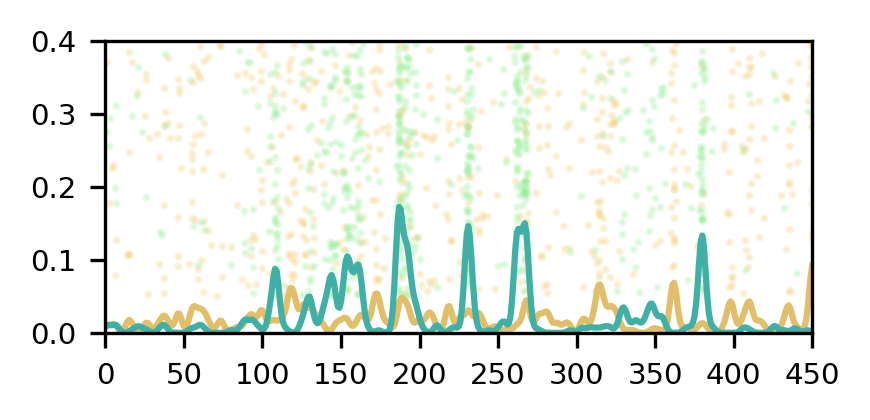

In [7]:
plot_behavioral_responses(affair_beh_data, paranoia_beh_data)

In [8]:
def plot_behavior_glmm(main_analysis, save_path=None, 
                             label=True, sort_by='effect_size', custom_feature_order=None,
                             group_names=None, colors=COLORS):
    """
    Create figure showing content feature effects for both groups in a single plot
    with different markers and color coding for significant effects.
    
    Parameters:
    -----------
    main_analysis : dict or numpy.ndarray
        Analysis results containing feature effects for different groups
    save_path : str, optional
        Path to save the figure
    figsize : tuple, optional
        Figure size (width, height)
    label : bool, optional
        Whether to show feature labels on the plot
    sort_by : str, optional
        How to sort features: 'effect_size', 'alphabetical', or 'probability'
    custom_feature_order : list, optional
        Custom ordering of features to display
    group_names : dict, optional
        Dictionary mapping group keys to display names (e.g., {'affair_group': 'Context A'})
    colors : dict, optional
        Dictionary with custom colors for each group
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure
    """
    # Set default group names if not provided
    if group_names is None:
        group_names = {
            'affair_group': 'Affair Group',
            'paranoia_group': 'Paranoia Group'
        }
    # Convert numpy array to dictionary if needed
    if isinstance(main_analysis, np.ndarray):
        results_dict = main_analysis.item()
    else:
        results_dict = main_analysis
    
    feature_results = results_dict['content_relationships']['feature_results']
    # Collect all available features
    all_features = list(feature_results.keys())
    
    print(f"Found {len(all_features)} features in data")
    
    # Data containers for each group
    affair_data = {
        'feature': [],
        'effect': [],
        'ci_lower': [],
        'ci_upper': [],
        'probability': []
    }
    
    paranoia_data = {
        'feature': [],
        'effect': [],
        'ci_lower': [],
        'ci_upper': [],
        'probability': []
    }
    
    # Populate data (using the same extraction logic as the original function)
    for feature in all_features:
        feature_data = feature_results[feature]
        
        # Skip if no group_specific_effects
        if 'group_specific_effects' not in feature_data:
            continue
            
        # Access group-specific effects
        group_specific = feature_data['group_specific_effects']
        
        # Special case: if we have a feature-specific structure with nested groups
        if len(group_specific) == 1 and feature in group_specific:
            # This is a special case where the feature is a key
            nested_group_data = group_specific[feature]
            
            # Add affair group data if it exists
            if 'affair_group' in nested_group_data and 'odds_ratio' in nested_group_data['affair_group']:
                affair_data['feature'].append(feature)
                affair_data['effect'].append(nested_group_data['affair_group'].get('odds_ratio', None))
                affair_data['ci_lower'].append(nested_group_data['affair_group'].get('lower', None))
                affair_data['ci_upper'].append(nested_group_data['affair_group'].get('upper', None))
                affair_data['probability'].append(nested_group_data['affair_group'].get('prob_positive', None))
            
            # Add paranoia group data if it exists
            if 'paranoia_group' in nested_group_data and 'odds_ratio' in nested_group_data['paranoia_group']:
                paranoia_data['feature'].append(feature)
                paranoia_data['effect'].append(nested_group_data['paranoia_group'].get('odds_ratio', None))
                paranoia_data['ci_lower'].append(nested_group_data['paranoia_group'].get('lower', None))
                paranoia_data['ci_upper'].append(nested_group_data['paranoia_group'].get('upper', None))
                paranoia_data['probability'].append(nested_group_data['paranoia_group'].get('prob_positive', None))
        else:
            # Standard case: direct group data
            if 'affair_group' in group_specific and 'odds_ratio' in group_specific['affair_group']:
                affair_data['feature'].append(feature)
                affair_data['effect'].append(group_specific['affair_group'].get('odds_ratio', None))
                affair_data['ci_lower'].append(group_specific['affair_group'].get('lower', None))
                affair_data['ci_upper'].append(group_specific['affair_group'].get('upper', None))
                affair_data['probability'].append(group_specific['affair_group'].get('prob_positive', None))
            
            # Add paranoia group data if it exists
            if 'paranoia_group' in group_specific and 'odds_ratio' in group_specific['paranoia_group']:
                paranoia_data['feature'].append(feature)
                paranoia_data['effect'].append(group_specific['paranoia_group'].get('odds_ratio', None))
                paranoia_data['ci_lower'].append(group_specific['paranoia_group'].get('lower', None))
                paranoia_data['ci_upper'].append(group_specific['paranoia_group'].get('upper', None))
                paranoia_data['probability'].append(group_specific['paranoia_group'].get('prob_positive', None))
    
    # Convert to DataFrames
    df_affair = pd.DataFrame(affair_data)
    df_paranoia = pd.DataFrame(paranoia_data)
    
    # If still no data, return empty figure
    if df_affair.empty and df_paranoia.empty:
        print("No valid data found for either group after all attempts")
        fig, ax = plt.subplots(figsize=figsize)
        ax.text(0.5, 0.5, "No valid data found for either group", 
                ha='center', va='center', fontsize=14)
        ax.axis('off')
        return fig
    
    # Determine common features between both groups
    common_features = set(df_affair['feature']).intersection(set(df_paranoia['feature']))
    
    # Filter to common features or use custom order if provided
    if custom_feature_order:
        # Filter to use only features in custom order
        df_affair = df_affair[df_affair['feature'].isin(custom_feature_order)]
        df_paranoia = df_paranoia[df_paranoia['feature'].isin(custom_feature_order)]
        
        # Sort according to custom order
        feature_order_dict = {f: i for i, f in enumerate(custom_feature_order)}
        df_affair['sort_key'] = df_affair['feature'].map(feature_order_dict)
        df_paranoia['sort_key'] = df_paranoia['feature'].map(feature_order_dict)
        
        df_affair = df_affair.sort_values('sort_key')
        df_paranoia = df_paranoia.sort_values('sort_key')
    else:
        # Filter to common features if needed
        if len(common_features) > 0:
            df_affair = df_affair[df_affair['feature'].isin(common_features)]
            df_paranoia = df_paranoia[df_paranoia['feature'].isin(common_features)]
        
        # Sort data if needed
        if sort_by == 'effect_size':
            # For combined plot, sort by overall effect magnitude
            if not df_affair.empty and not df_paranoia.empty:
                # Create a combined effect score
                common_features_list = list(common_features)
                effect_scores = {}
                
                for feature in common_features_list:
                    affair_effect = df_affair.loc[df_affair['feature'] == feature, 'effect'].values[0]
                    paranoia_effect = df_paranoia.loc[df_paranoia['feature'] == feature, 'effect'].values[0]
                    # Use maximum distance from 1 as sort key
                    effect_scores[feature] = max(abs(affair_effect - 1), abs(paranoia_effect - 1))
                
                # Sort both dataframes by this combined score
                sorted_features = sorted(effect_scores.keys(), 
                                        key=lambda f: effect_scores[f], 
                                        reverse=True)
                
                feature_order_dict = {f: i for i, f in enumerate(sorted_features)}
                
                df_affair['sort_key'] = df_affair['feature'].map(feature_order_dict)
                df_paranoia['sort_key'] = df_paranoia['feature'].map(feature_order_dict)
                
                df_affair = df_affair.sort_values('sort_key')
                df_paranoia = df_paranoia.sort_values('sort_key')
            else:
                # Sort each individually if only one has data
                if not df_affair.empty:
                    df_affair['sort_key'] = abs(df_affair['effect'] - 1)
                    df_affair = df_affair.sort_values('sort_key', ascending=False)
                if not df_paranoia.empty:
                    df_paranoia['sort_key'] = abs(df_paranoia['effect'] - 1)
                    df_paranoia = df_paranoia.sort_values('sort_key', ascending=False)
        elif sort_by == 'alphabetical':
            # Sort alphabetically
            df_affair = df_affair.sort_values('feature')
            df_paranoia = df_paranoia.sort_values('feature')
    
    # Create figure with a single plot
    if label:
        figsize = (4, 3)
    else:
        figsize = (4, 2)
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get all unique features from both dataframes
    all_plot_features = pd.concat([df_affair['feature'], df_paranoia['feature']]).unique()
    
    # Create x positions
    x_pos = np.arange(len(all_plot_features))
    feature_positions = {feature: i for i, feature in enumerate(all_plot_features)}
    
    # Plot reference line at odds ratio = 1 (no effect)
    ax.axhline(y=1, color='gray', linestyle='-', alpha=0.7, linewidth=0.5)
        
    def adjust_color_alpha(color, alpha_factor):
        """Adjust the alpha/intensity of a color"""
        rgb = mpl.colors.ColorConverter.to_rgb(color)
        return tuple([c * alpha_factor + (1-alpha_factor) for c in rgb])
    
    color_high_affair = colors['affair']
    color_med_affair = adjust_color_alpha(colors['affair'], 0.7)
    color_low_affair = adjust_color_alpha(colors['affair'], 0.4)
    gray_color = '#777777'
    
    
    # Plot affair group data
    for i, (_, row) in enumerate(df_affair.iterrows()):
        feature_idx = feature_positions[row['feature']]
        
        # Check if CI crosses 1 (null effect for odds ratio)
        
        # Get the posterior probability
        prob = row['probability']
        
        # For odds ratios, probability should be interpreted as:
        # - If odds ratio > 1: probability that effect is positive
        # - If odds ratio < 1: probability that effect is negative
        # Ensure probability is always > 0.5 by taking max(p, 1-p)
        directional_prob = max(prob, 1-prob) if prob is not None else 0.5
        
        # Determine color based on directional probability
        if directional_prob > 0.999:
            point_color = color_high_affair
        elif directional_prob > 0.99:
            point_color = color_med_affair  
        elif directional_prob > 0.95:
            point_color = color_low_affair
        else:
            point_color = gray_color
        
        # Plot CI line
        ax.vlines(x=feature_idx - 0.15, ymin=row['ci_lower'], ymax=row['ci_upper'], 
                 color=point_color, alpha=0.7, linewidth=1)
        
        # Plot point - use "o" marker for affair group
        ax.scatter(feature_idx - 0.15, row['effect'], color=point_color, s=10, 
                  marker='o', zorder=3, label=group_names['affair_group'] if feature_idx == 0 else "")
        
        # # Add probability annotation if high confidence
        # if directional_prob > 0.99:
        #     text_y = row['ci_upper'] + (row['ci_upper'] - row['ci_lower']) * 0.1
        #     ax.text(x_pos[i]-0.15, text_y, f"{directional_prob:.3f}", 
        #             ha='center', va='bottom', fontsize=7, color=point_color, alpha=0.8)
    
    color_high_paranoia = colors['paranoia']
    color_med_paranoia = adjust_color_alpha(colors['paranoia'], 0.7)
    color_low_paranoia = adjust_color_alpha(colors['paranoia'], 0.4)
    
    # Plot paranoia group data
    for i, (_, row) in enumerate(df_paranoia.iterrows()):
        feature_idx = feature_positions[row['feature']]

        # Check if CI crosses 1 (null effect for odds ratio)
        ci_crosses_one = (row['ci_lower'] <= 1 and row['ci_upper'] >= 1)
        
        # Get the posterior probability
        prob = row['probability']
        
        # For odds ratios, probability should be interpreted as:
        # - If odds ratio > 1: probability that effect is positive
        # - If odds ratio < 1: probability that effect is negative
        # Ensure probability is always > 0.5 by taking max(p, 1-p)
        directional_prob = max(prob, 1-prob) if prob is not None else 0.5
        
        # Determine color based on directional probability
        if directional_prob > 0.999:
            point_color = color_high_paranoia   
        elif directional_prob > 0.99:
            point_color = color_med_paranoia  
        elif directional_prob > 0.95:
            point_color = color_low_paranoia
        else:
            point_color = gray_color
        
        # Determine color based on probability threshold
        # point_color = get_color(row['probability'], colors['paranoia'])
        
        # Plot CI line
        ax.vlines(x=feature_idx + 0.15, ymin=row['ci_lower'], ymax=row['ci_upper'], 
                 color=point_color, alpha=0.7, linewidth=1)
        
        # Plot point - use "^" marker for paranoia group
        ax.scatter(feature_idx + 0.15, row['effect'], color=point_color, s=10, 
                  marker='^', zorder=3, label=group_names['paranoia_group'] if feature_idx == 0 else "")
        
         # Add probability annotation if high confidence
        # if directional_prob > 0.99:
        #     text_y = row['ci_upper'] + (row['ci_upper'] - row['ci_lower']) * 0.1
        #     ax.text(x_pos[i]+0.15, text_y, f"{directional_prob:.3f}", 
        #             ha='center', va='bottom', fontsize=7, color=point_color, alpha=0.8)
    
    # Add legend
    # handles, labels = ax.get_legend_handles_labels()
    # # Remove duplicate labels
    # by_label = dict(zip(labels, handles))
    # ax.legend(by_label.values(), by_label.keys(), loc='upper left')
    
    
    # Use log scale for y-axis (better for odds ratios)
    ax.set_yscale('log')
    
    # Add x-axis labels
    if label:
         # Set y-axis label
        ax.set_ylabel("Odds Ratio")
        ax.set_xticks(x_pos)
        feature_labels = [f.replace('_', ' ').replace('has ', '').title() for f in all_plot_features]
        ax.set_xticklabels(feature_labels, rotation=90, ha='center')
    else:
         # Set y-axis label
        ax.set_ylabel("")
        ax.set_xticks([])
        ax.set_xticklabels([])
    
    # Add title
    # ax.set_title("Brain State Effects by Group", fontsize=12)
    
    # Add grid
    ax.grid(axis='y', linestyle=':', alpha=0.3)
    
    # # Set fixed y-ticks for better comparison
    
    ax.set_yticks([0.1, 1.0, 4])
    ax.set_yticklabels(['0.1', '1.0', '4.0'])
    
    # Calculate y-limits with padding
    if not df_affair.empty and not df_paranoia.empty:
        min_effect = min(df_affair['effect'].min(), df_paranoia['effect'].min())
        max_effect = max(df_affair['effect'].max(), df_paranoia['effect'].max())
        
        min_ci = min(df_affair['ci_lower'].min(), df_paranoia['ci_lower'].min())
        max_ci = max(df_affair['ci_upper'].max(), df_paranoia['ci_upper'].max())
    elif not df_affair.empty:
        min_effect = df_affair['effect'].min()
        max_effect = df_affair['effect'].max()
        min_ci = df_affair['ci_lower'].min()
        max_ci = df_affair['ci_upper'].max()
    else:
        min_effect = df_paranoia['effect'].min()
        max_effect = df_paranoia['effect'].max()
        min_ci = df_paranoia['ci_lower'].min()
        max_ci = df_paranoia['ci_upper'].max()
    
    global_min = min(min_effect, min_ci)
    global_max = max(max_effect, max_ci)
    
    # Add padding factor for log scale (multiplicative)
    padding_factor = 1.2
    global_y_min = global_min / padding_factor
    global_y_max = global_max * padding_factor
    
    # ax.set_ylim(global_y_min, global_y_max)
    ax.set_xlim(-0.5, len(all_plot_features) - 0.5)
    
    plt.tight_layout()
    # Save figure if requested
    if save_path:
        suffix = "_label" if label else "_nolabel"
        plt.savefig(SAVE_DIR_FIG5 / f'{save_path}{suffix}.png', dpi=300, bbox_inches='tight')
        plt.savefig(SAVE_DIR_FIG5 / f'{save_path}{suffix}.svg', dpi=300, bbox_inches='tight')

    
    plt.close()
    return fig

In [9]:
file = Path(OUTPUT_DIR) / '09_behavior_content_glmm_bin_1s' / 'deviation' / 'behavioral_content_analysis_1s.json'
with open(file, 'r') as f:
    data = json.load(f)

Found 10 features in data


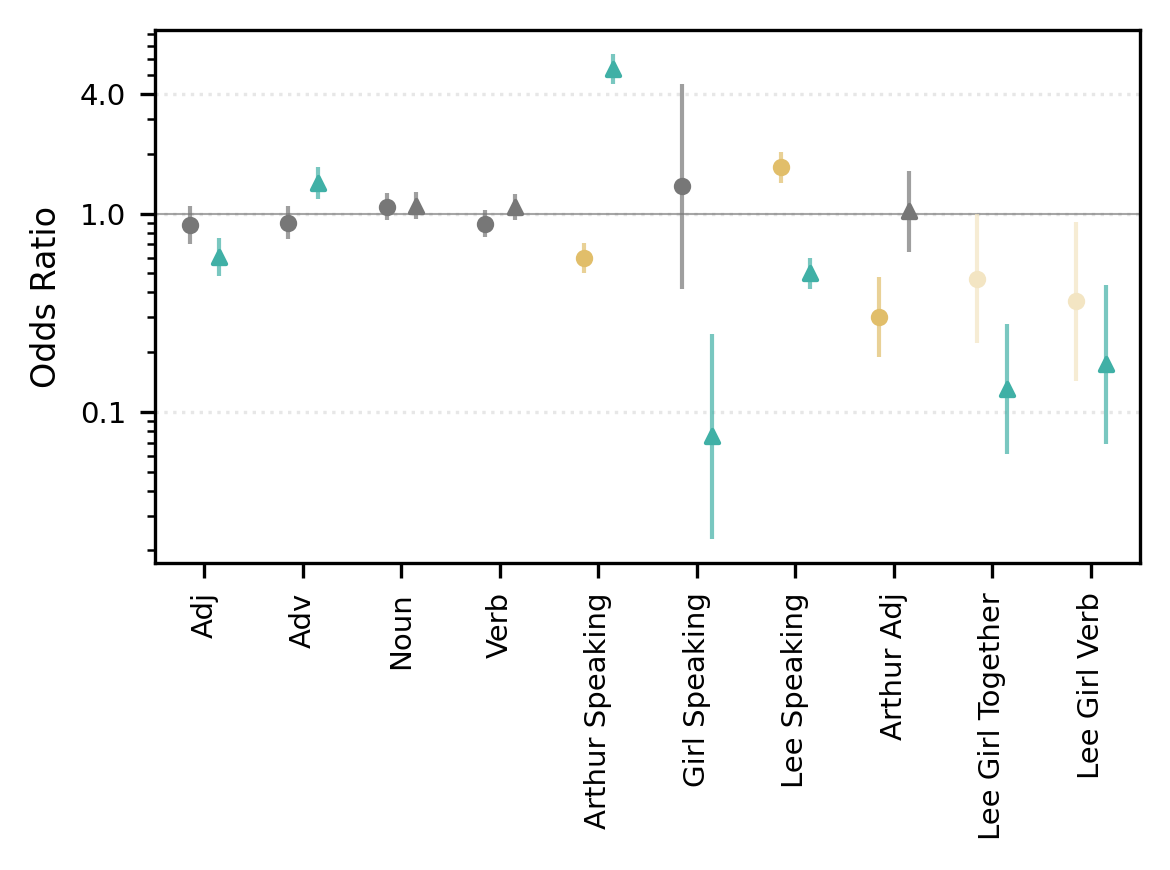

In [10]:
plot_features = ['has_adj', 'has_adv', 'has_noun', 'has_verb', 'arthur_speaking', 
                     'girl_speaking', 'lee_speaking', 'arthur_adj', 'lee_girl_together', 
                     'lee_girl_verb']
plot_behavior_glmm(data, custom_feature_order=plot_features, save_path="glmm_behavior")

Found 10 features in data


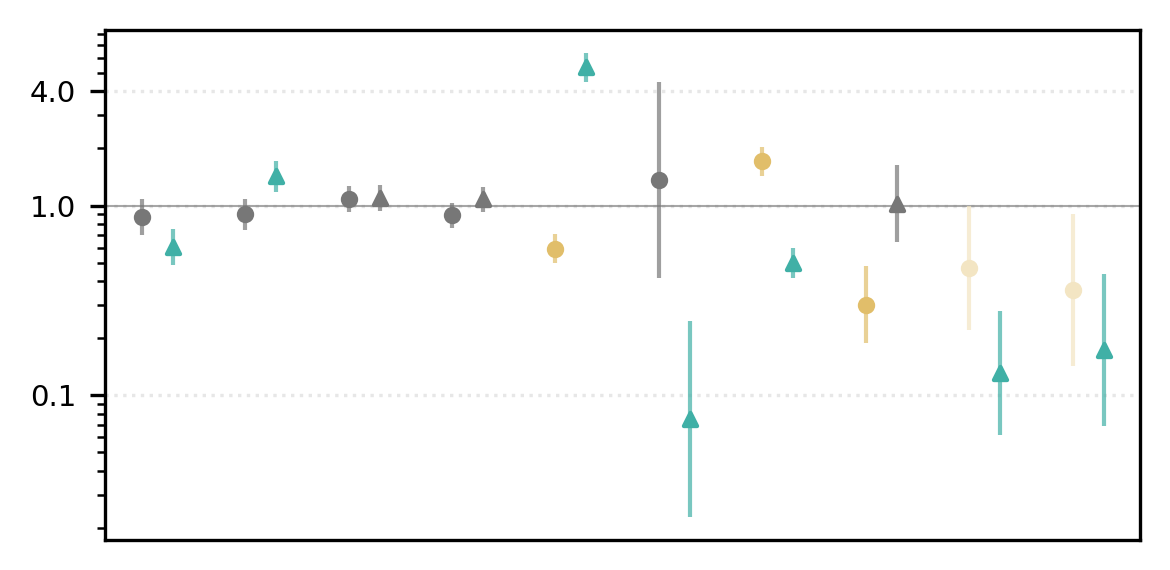

In [11]:
plot_behavior_glmm(data, custom_feature_order=plot_features, label=False, save_path="glmm_behavior")